In [3]:
library('forecast');
library('astsa');
library('fpp2');
library('ggplot2')

## Simple forecasting methods

The **average method** for forecasting predicts that all future values will be the mean of the historical data. 

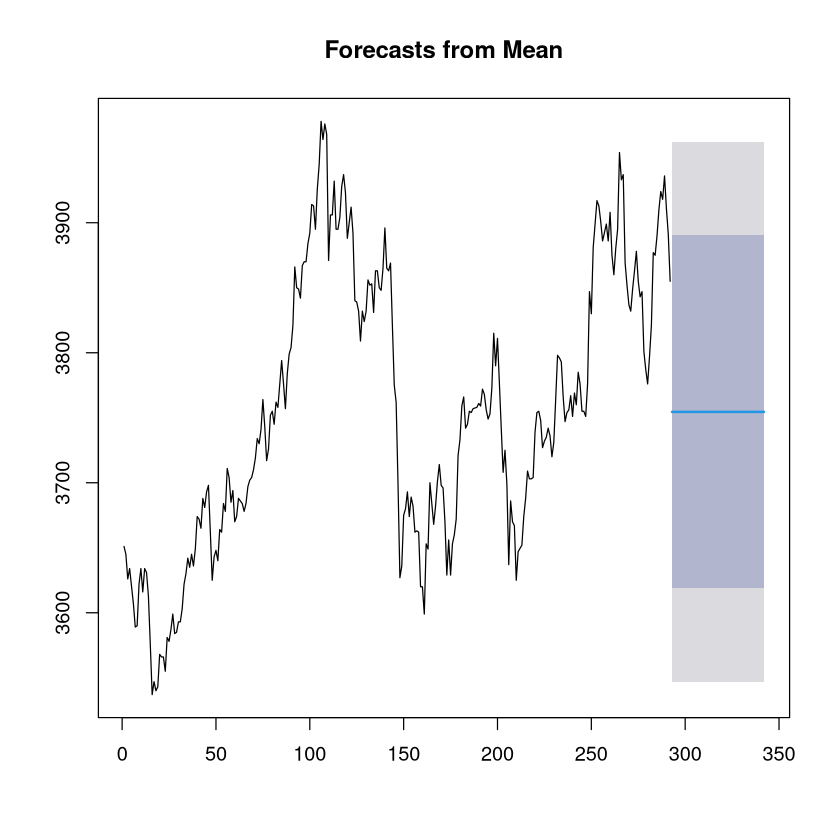

In [4]:
plot(meanf(dj, 50))

The **naive method** sets all forecast values to be the value of the last observation. It is also called **random walk forecast**.

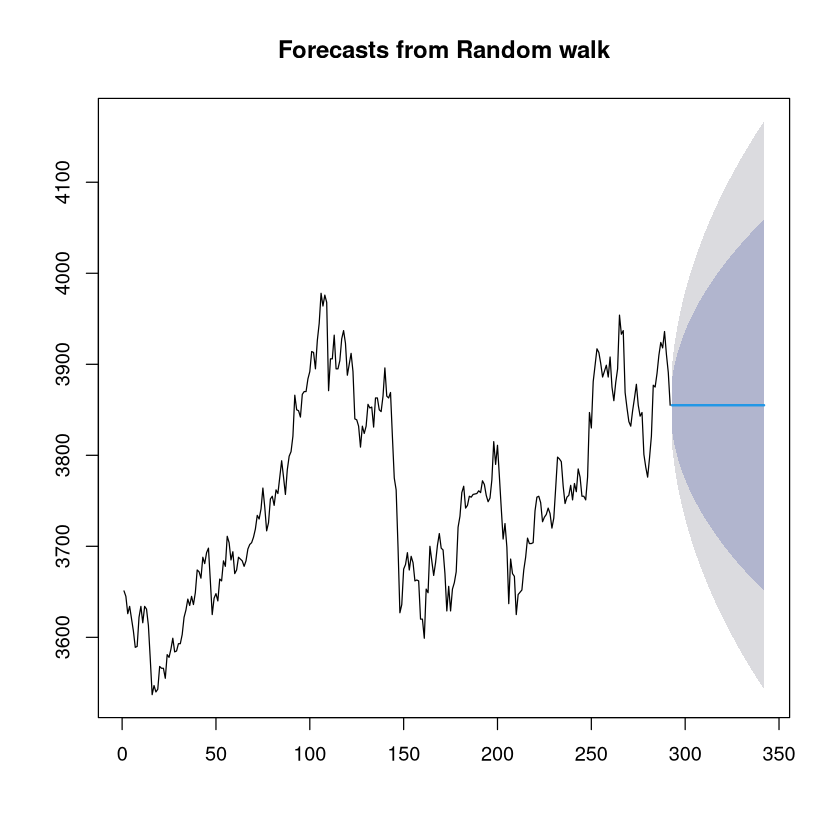

In [5]:
plot(rwf(dj, 50))

A variation on the naive method is the **drift method**, which essentially draws a straight line between the first and last observations, and extrapolates that line into the future. That is, $$\hat y_{T+h|T} = y_T + h(\frac{y_T - y_1}{T-1}).$$

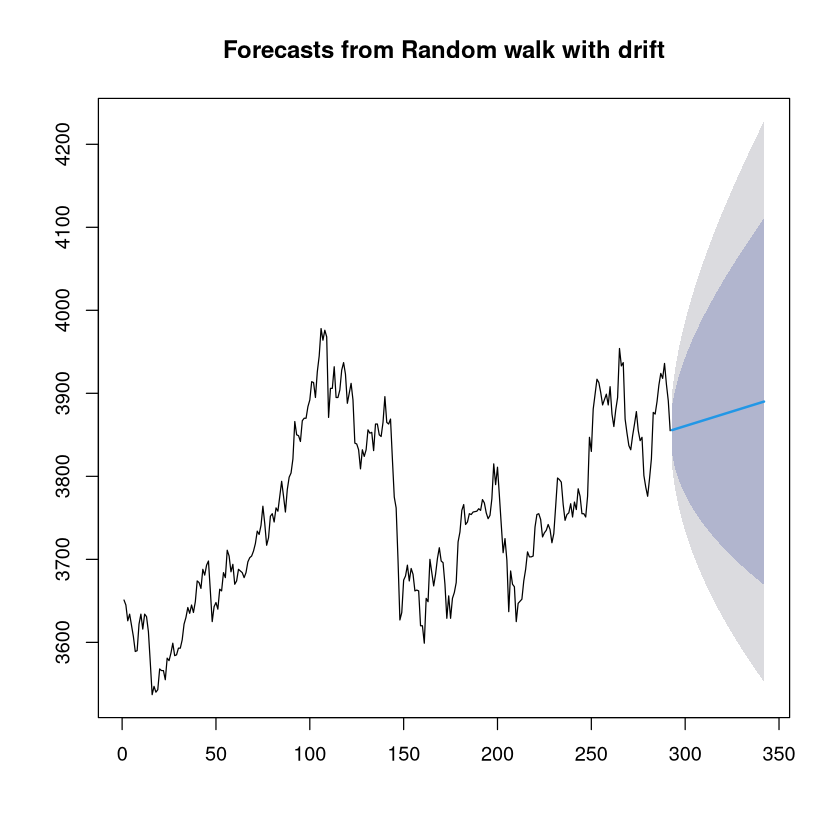

In [6]:
plot(rwf(dj, 50, drift=1))

The **seasonal naive method** sets the forecast equal to the last observed value from the same season of the previous year/period. Formally, the forecast for time $T+h$ is $$\hat y_{T_h|T} = y_{T+h-m(k+1)}$$ where $m$ is the period of each season, and $k$ is the smallest integer greater than $(h-1)/m$.

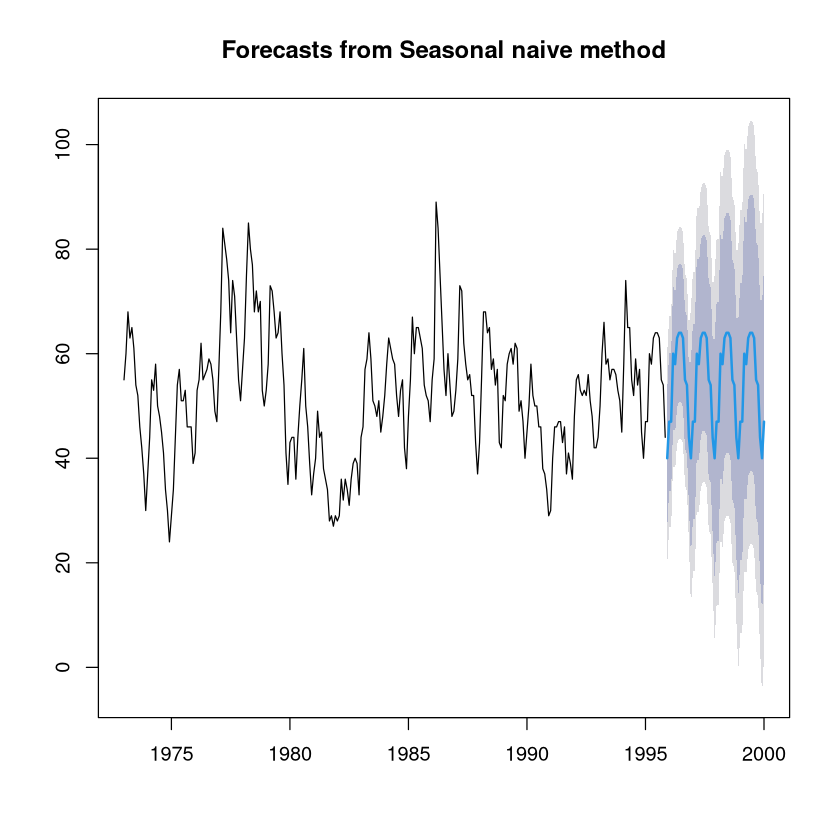

In [7]:
plot(snaive(hsales, 50))

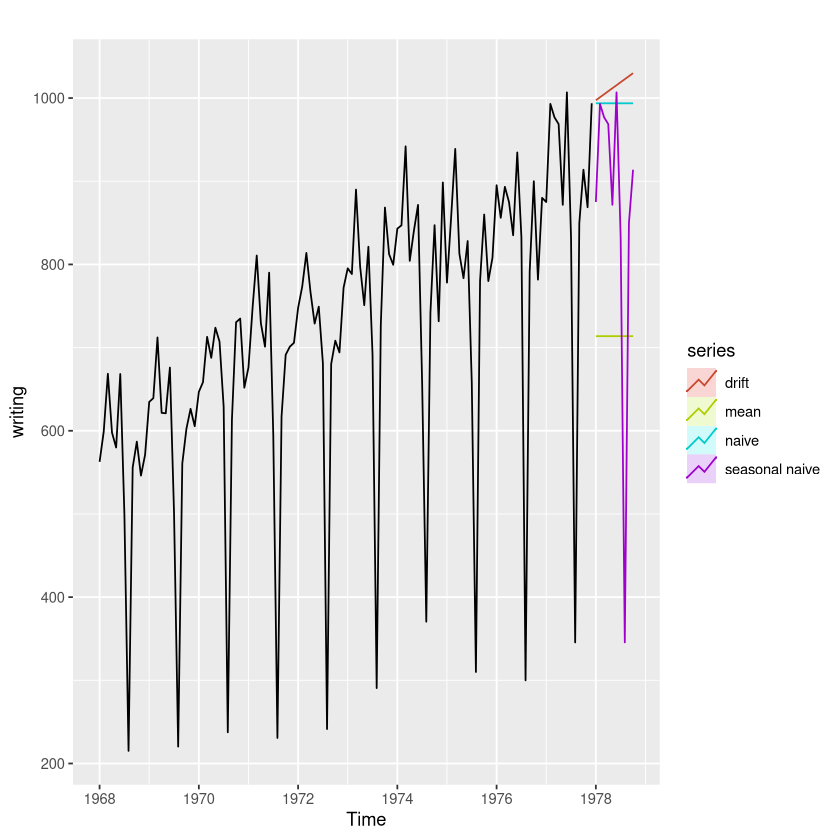

In [8]:
autoplot(writing) +
    autolayer(meanf(writing, h=10), PI=0, series='mean') +
    autolayer(rwf(writing, h=10), PI=0, series='naive') +
    autolayer(rwf(writing, h=10, drift=1), PI=0, series='drift') +
    autolayer(snaive(writing, h=10), PI=0, series='seasonal naive')

These simple methods serve more as benchmarks. If we develop a more complex method, we should ensure that it is at least as good as these simple methods. Otherwise, it is not worth considering.

## Transformations and adjustments

**Calendar adjustments**: since some time series are in the form of monthly or quarterly data, there is a variation between months because of the different number of days in each month. We can adjust for this by converting this data into daily average data.

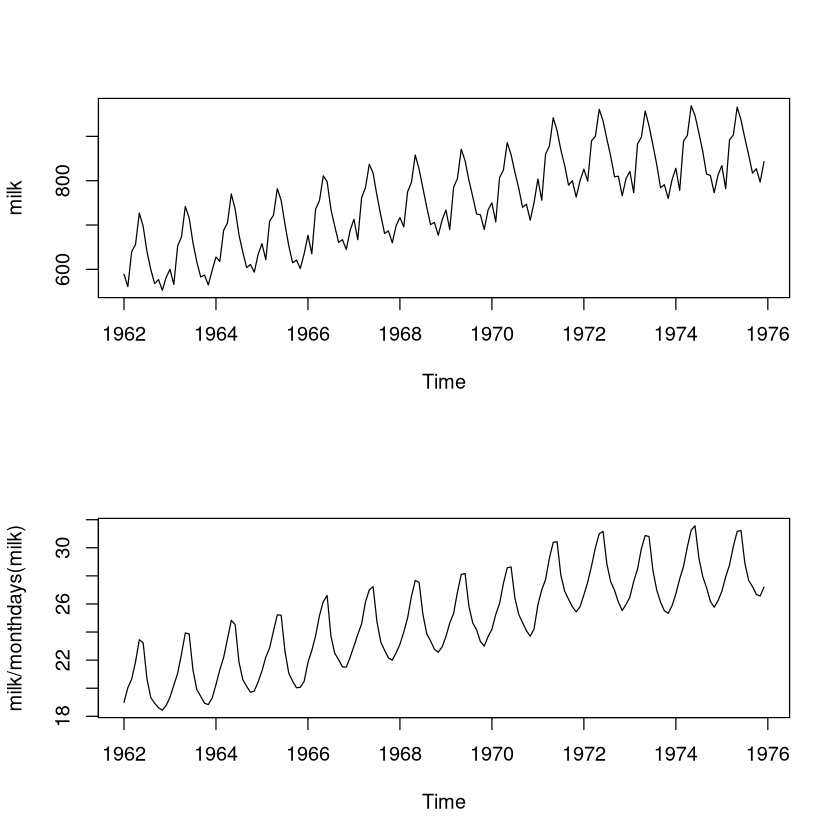

In [9]:
par(mfrow=c(2, 1))
plot(milk)
plot(milk / monthdays(milk))

**Population adjustments**: for data that are affected by population changes, it makes more sense to convert the data to per-capita data. 

**Inflation adjustments**: for data that are affected by the value of money, it is best to standardize the dollar value by converting it all the dollar value in a particular year.

A **power transformation** transforms data by existing data points $y_t$ and transforming them into some $w_t = y_t^p$. The purpose of doing so is to stabilize the variance in the time series. That is, if the variance in one section of the time series is larger than that in another section, a power transformation can make the data easier to work with. 

A type of power transformation is the **Box-Cox transformation**, which takes in a parameter $\lambda$ and is defined by: 

$$ w_t = \begin{cases} \ln(y_t) & {\rm if \lambda = 0} \\ (y_t^\lambda - 1)/\lambda & {\rm otherwise} \end{cases}$$

A good value of $\lambda$ will make it so that the size of the seasonal variation is about the same across the whole series. That makes forecasting easier. After performing this transformation and forecasting on the transformed time series, the transformation must be undone. This is done by applying the following function:

$$ y_t = \begin{cases} \exp(w_t) & {\rm if \lambda = 0} \\ (\lambda w_t + 1)^{1/\lambda} & {\rm otherwise} \end{cases}$$

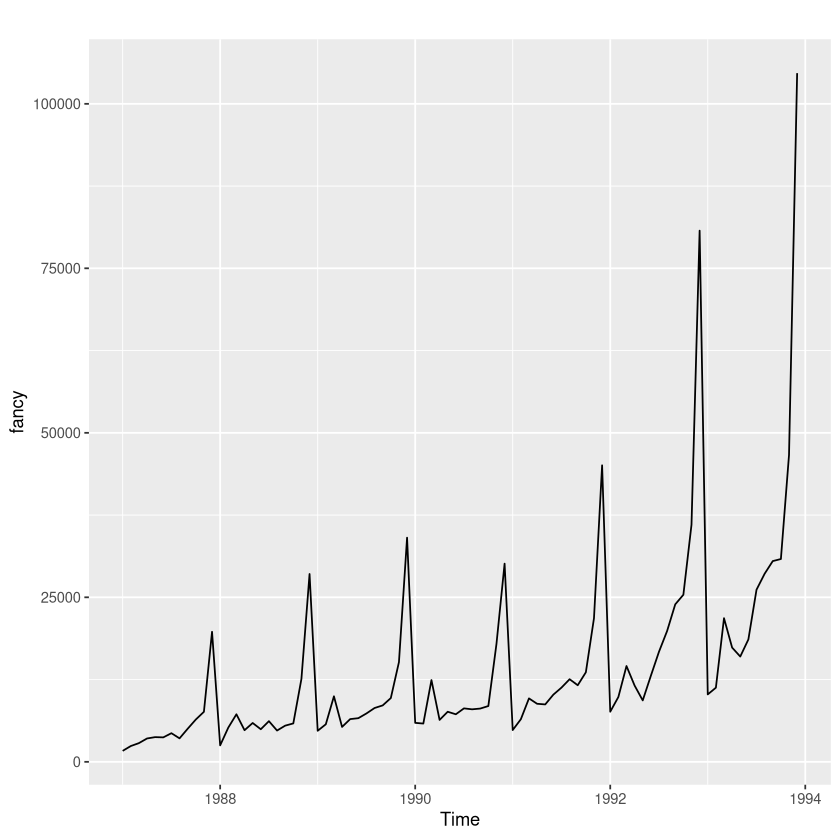

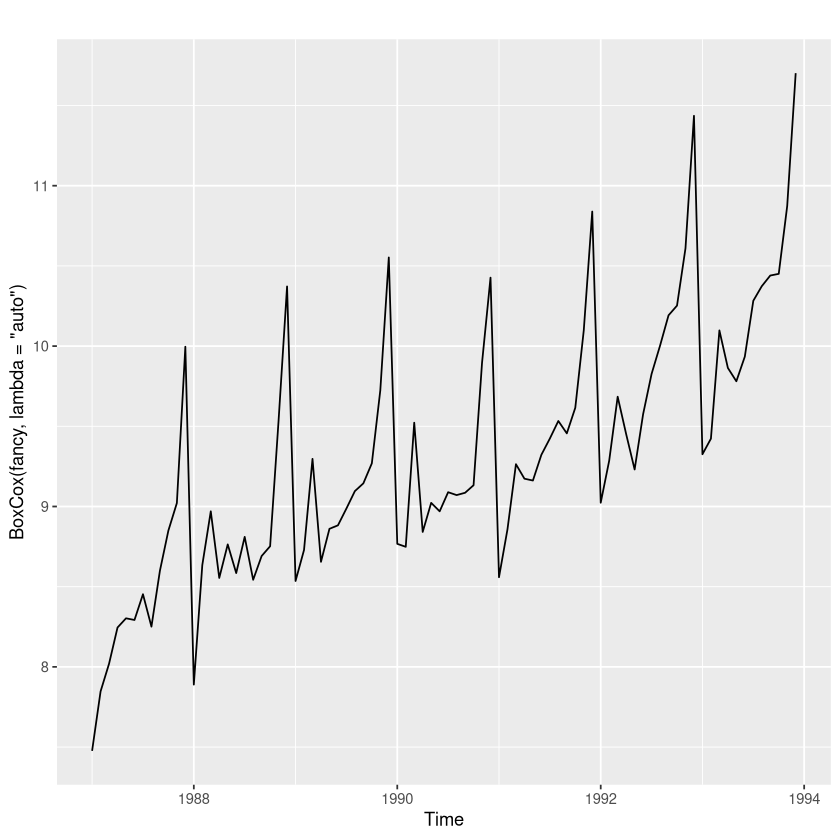

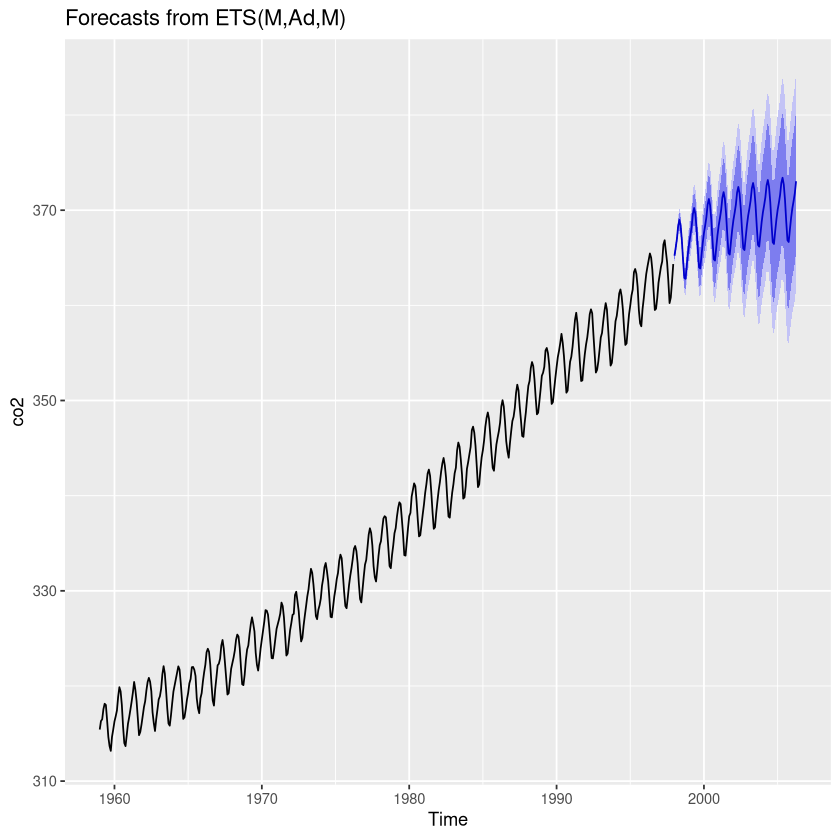

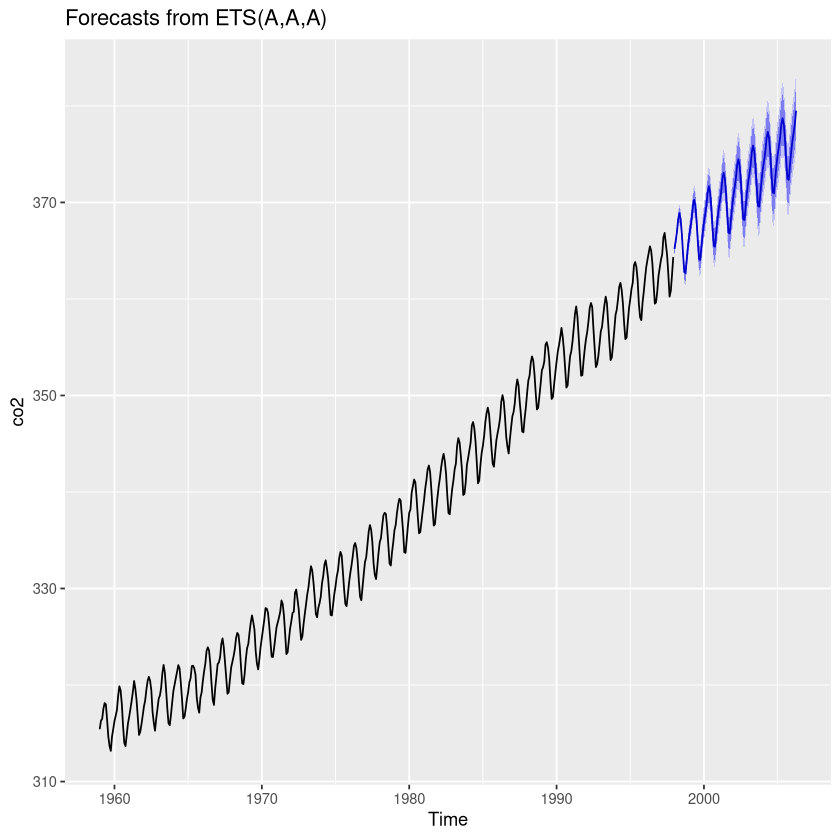

In [10]:
autoplot(fancy)
autoplot(BoxCox(fancy, lambda='auto'))
autoplot(forecast(co2, h=100))
autoplot(forecast(co2, h=100, lambda='auto'))

Doing a transformation such as Box-Cox and then back-transforming gives the median of the forecast distribution. In some cases, we want the mean rather than the median. This is true in cases where you may want to add up component forecasts to arrive at a total—the means add up, but the medians don't. The difference between the median forecast and the mean forecast is called the **bias**. If we use the mean rather than the median, we say that the point forecasts have been **bias-adjusted**.

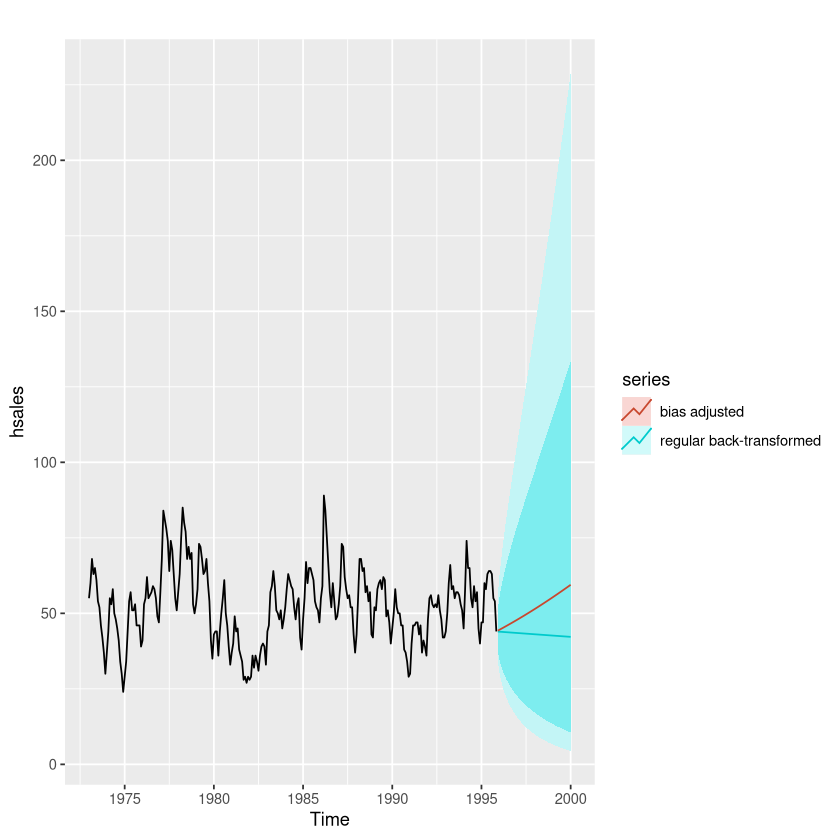

In [11]:
autoplot(hsales) +
    autolayer(rwf(hsales, h=50, drift=1, lambda='auto'), series='regular back-transformed') +
    autolayer(rwf(hsales, h=50, drift=1, lambda='auto', biasadj=TRUE), series='bias adjusted', PI=0) 

## Residual diagnostics

**Residuals**, or errors, are the difference between the observations and the predictions. Checking the residuals is useful for determining whether a forecasting model has captured the information in the data. 

A good model yields residuals with the following properties:

1. Residuals are uncorrelated (independent). 
2. Residuals have zero mean. 
3. Residuals have the same variance (possibly unknown). 
4. Residuals are normally distributed. 

A model that does not satisfy properties 1 or 2 can be improved, but this is not necessarily the case for properties 3 and 4. 

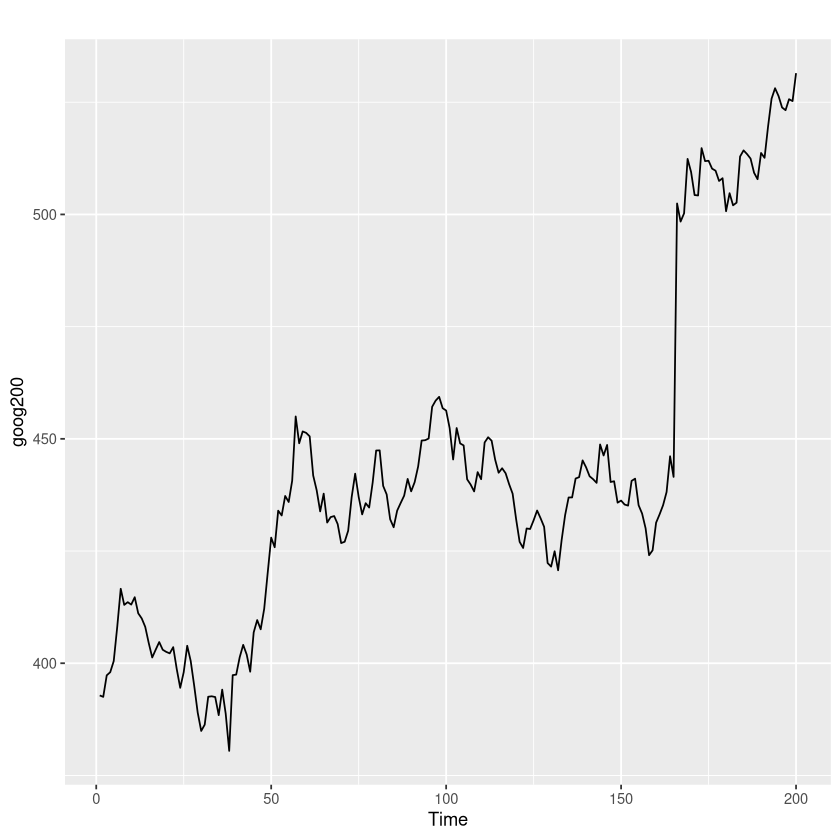

In [12]:
autoplot(goog200)

We can analyze the residuals of a forecast using the naive method:

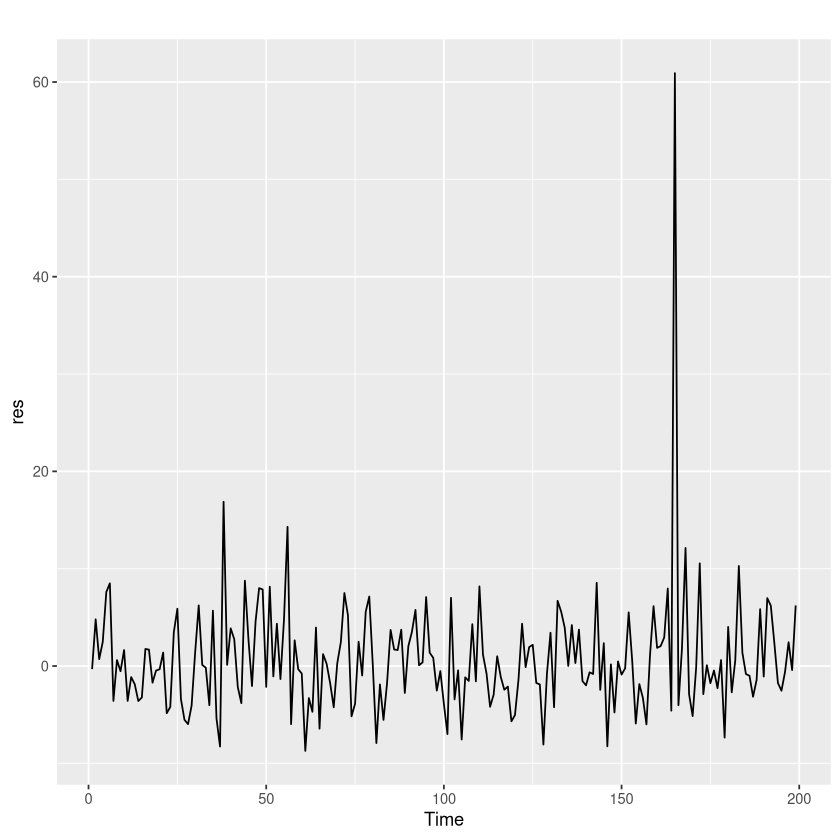

In [13]:
res <- ts(resid(naive(goog200))[-1])
autoplot(res)

The variance looks to be constant throughout the residuals, apart from the outlier.

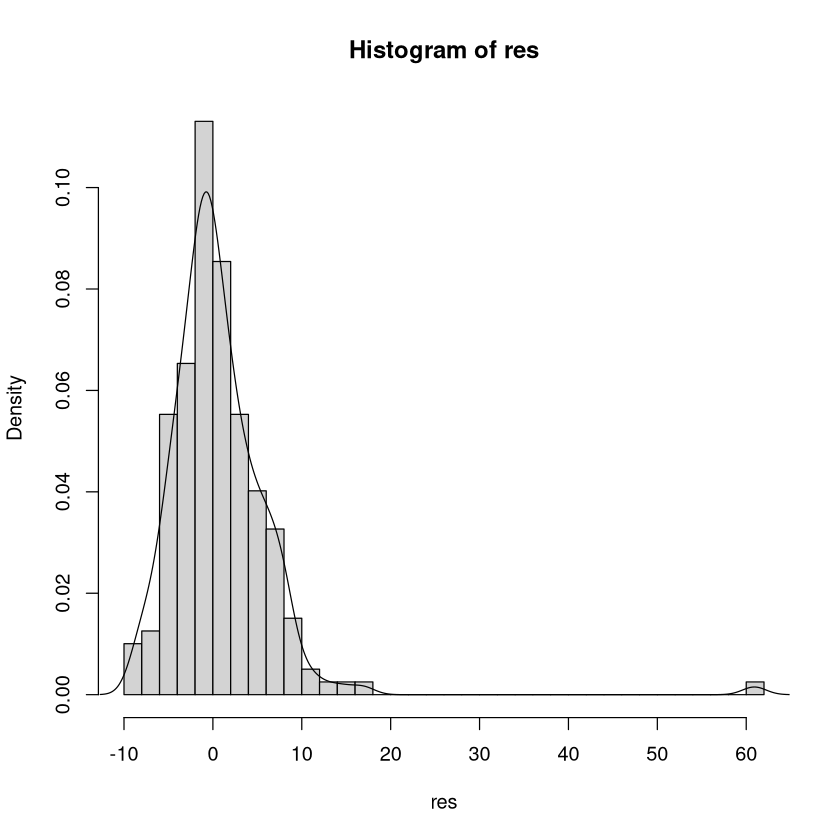

In [14]:
hist(res, freq=0, breaks=30)
lines(density(res))

The mean looks to be about zero, which is good. However, the right tail of the histogram looks a little too long, even if the outlier is ignored. This means the assumption of normality may not be accurate. We can use a QQ-plot to check. 

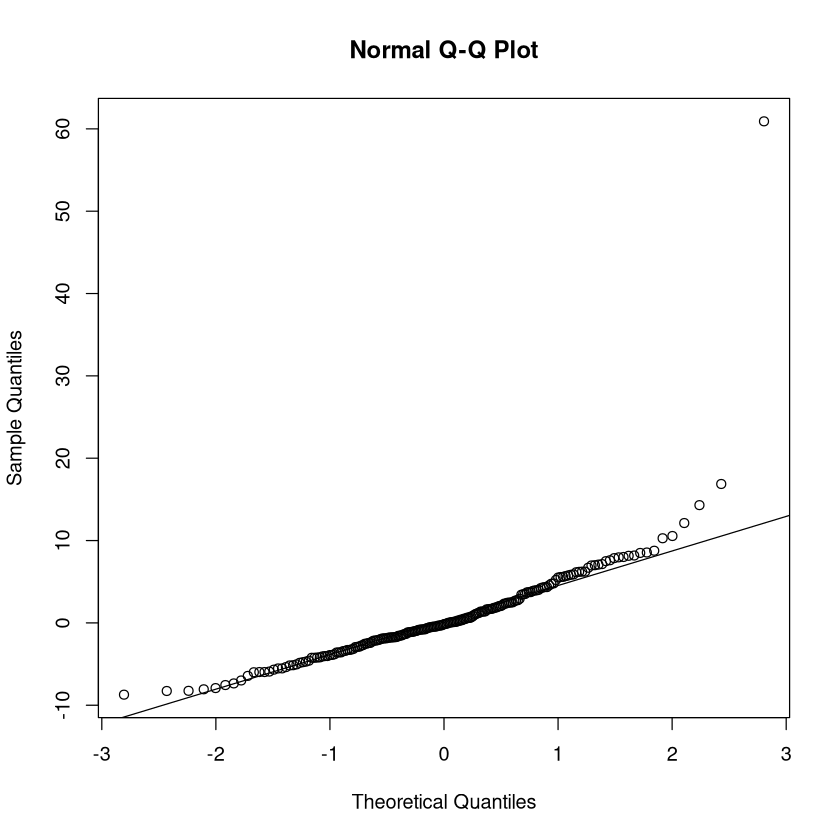

In [15]:
qqnorm(res)
qqline(res)

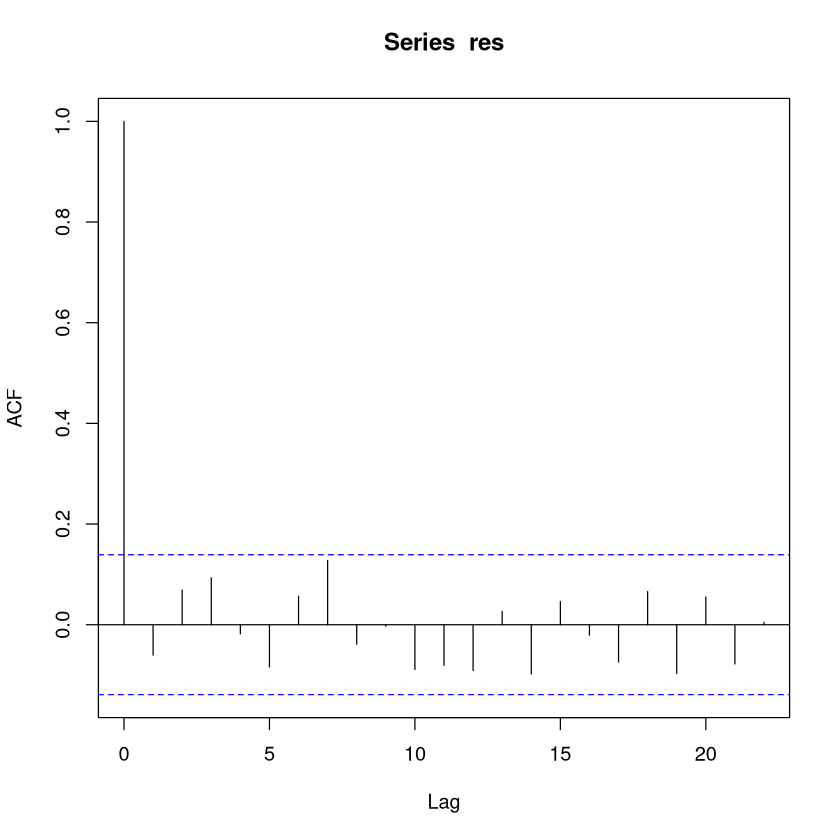

In [16]:
acf(res)

The residuals look to be uncorrelated, which is good. However, we can perform a more rigorous analysis as to whether this is true. 

We can think of the ACF plot as running a hypothesis test at each lag interval. Given enough tests, it is likely that there will be a false positive, and we may falsely conclude that the residuals have some remaining autocorrelation. To correct for this, we test the "overall" randomness based on a number of different lags using the **Ljung-Box test** (an improved version of the Box-Pierce test). 

The Ljung-Box test is defined as:

**H_0**: The data are independently distributed. The correlations in the population from which the sample is taken are 0, so any observed correlations result from randomness in the sampling process. 

**H_1**: The data are not independently distributed. They exhibit serial correlation. 

The test statistic is:

$$Q = n(n+2)\sum_{k=1}^h \frac{\hat{\rho}_k^2}{n-k}$$

where $n$ is the sample size, $\hat{\rho}_k$ is the sample autocorrelation at lag $k$, and $h$ is the maximum lag being considered. Under $H_0$, the test statistic $Q$ follows $\chi_{df=h}^2$. For significance level $\alpha$, the rejection region is

$$Q > \chi_{1-\alpha, (df=h)}$$

Heuristics for choosing $h$:
- for non-seasonal data, use $h=10$
- for seasonal data, use $h=2m$, where $m$ is the period of seasonality
- if the above values are larger than $n/5$, use $h=n/5$ instead

In [17]:
Box.test(res, lag=10, type="Lj")


	Box-Ljung test

data:  res
X-squared = 11.031, df = 10, p-value = 0.3551


For our test, the results are not significant. The p-value is 0.3551 > 0.05, so we fail to reject the null hypothesis. We conclude that it is reasonable to assume that the data are independently distributed.


	Ljung-Box test

data:  Residuals from Naive method
Q* = 11.031, df = 10, p-value = 0.3551

Model df: 0.   Total lags used: 10



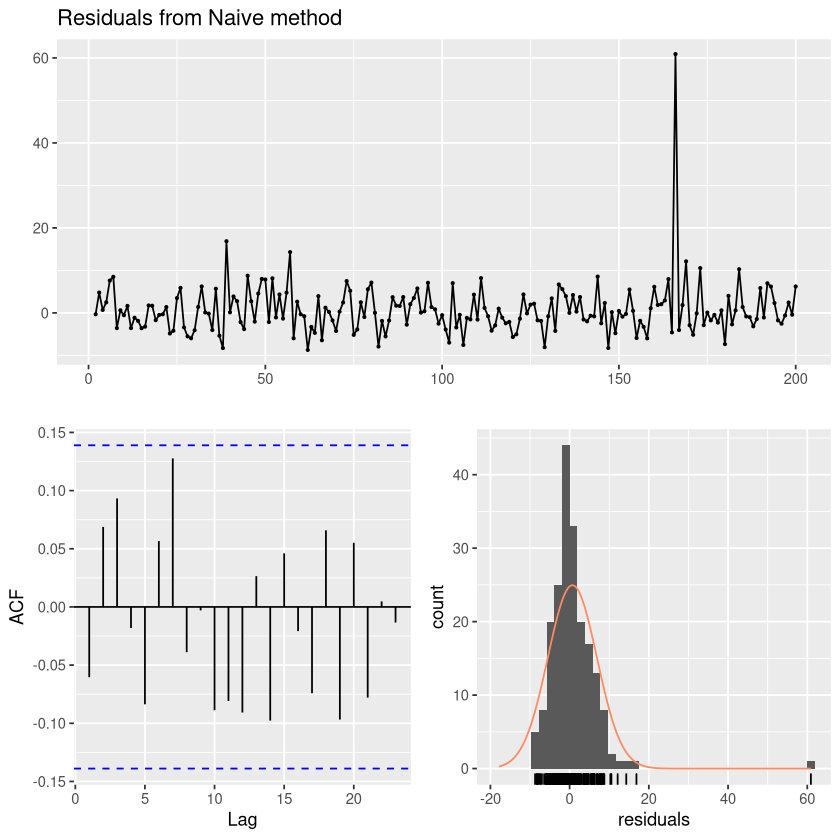

In [18]:
# a convenient function to do all the above...

checkresiduals(naive(goog200))

## Evaluating Forecast Accuracy

We can use genuine data to evaluate the accuracy of our forecasts. This is done by separating the data into **training** and **testing** sets.The data is trained on (usually) 80% of the data, and tested on the remaining 20%. 

A good model doesn't **overfit** or **underfit**. Overfitting is when the model fits the training data really well (which can always be done by adding a lot of parameters) but doesn't generalize/forecast well, and underfitting is when the model can't identify patterns in the data (too few parameters, usually). 

`window`, `subset`, and `tail` can be used to split data.

In [19]:
window(ausbeer, start=2005)
subset(ausbeer, start=length(ausbeer)-4*5)
tail(ausbeer, 4*5)

,Qtr1,Qtr2,Qtr3,Qtr4
2005,416,403,408,482
2006,438,386,405,491
2007,427,383,394,473
2008,420,390,410,488
2009,415,398,419,488
2010,414,374,,


,Qtr1,Qtr2,Qtr3,Qtr4
2005,,403,408,482
2006,438,386,405,491
2007,427,383,394,473
2008,420,390,410,488
2009,415,398,419,488
2010,414,374,,


,Qtr1,Qtr2,Qtr3,Qtr4
2005,,,408,482
2006,438,386,405,491
2007,427,383,394,473
2008,420,390,410,488
2009,415,398,419,488
2010,414,374,,


**Forecast error** is the difference between the observed value and the forecast:

$$e_{T+h} = y_{T+h} - \hat{y}_{T+h|T},$$

where $e_{T+h}$ is the forecast error at time $T+h$, $y_{T+h}$ is the observed value at time $T+h$ and $\hat{y}_{T+h|T}$ is the forecast for $T+h$ (given the value at time $T$. 

Note that *forecast errors are not the same as residuals*. Residuals are calculated on the training set and are based on one-step forecasts. On the other hand, forecast errors are calculated on the test set and can involve multi-step forecasts.

Accuracy measures that are only based on $e_t$ are **scale-dependent** (same scale as the data) cannot be used to make comparisons between series that involve different units/scales. 

The two most common scale-dependent measures are:

$$\text{mean absolute error: MAE = mean}(|e_t|)$$
$$\text{root mean squared error: RMSE = mean}\sqrt{e_t^2}$$

**Forecast methods that minimize the MAE forecast the median, and those that minimize the RMSE forecast the mean.**

The **percentage error** is unit-free, and can be used to compare forecast performance between different datasets. It is defined as

$$p_t = 100\frac{e_t}{y_t}.$$

A common measure of the percentage error is:

$$\text{mean absolute percentage error: MAPE = mean}(|p_t|)$$

Percentage-error based measures are not defined if $y_t=0$ for any $t$, and assume that the unit of measure has a meaningful zero (eg. it doesn't make sense for a temperature forecast on the Celsius scale, because the zero-point is arbitrarily defined). 

Another way to compare forecast accuracy across series with different units is to use **scaled errors**. 

For non-seasonal time series, we can define a scaled error as:

$$q_j = \frac{e_j}{\frac{1}{T-1}\sum_{t=2}^{T}|y_t - y_{t-1}|},$$

and for seasonal time series,

$$q_j = \frac{e_j}{\frac{1}{T-m}\sum_{t=m+1}^{T}|y_t - y_{t-m}|}.$$

The scale will cancel out so that the resulting $q_j$ is independent of the scale. $q_j<1$ if the forecast is better than a (seasonal) naive forecast, and $q_j>1$ is the forecast is worse than a (seasonal) naive forecast.

Then we can define a measure using $q_j$:

$$\text{mean absolute scaled error: MASE = mean}(|q_j|)$$


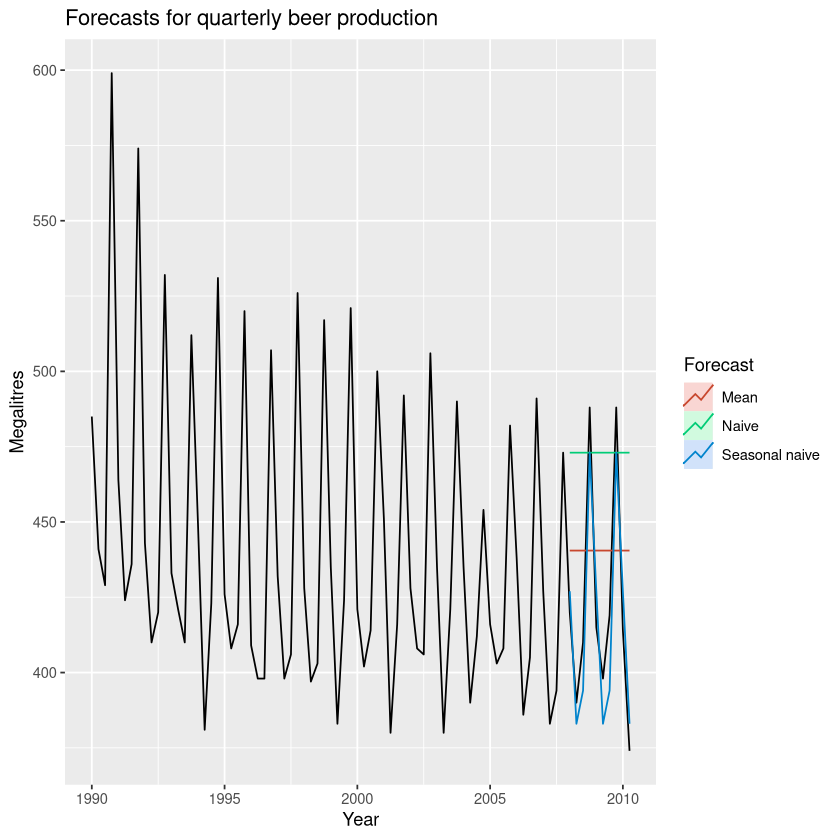

In [27]:
beer2 <- window(ausbeer, start=1990, end=c(2007, 4))
fit1 <- meanf(beer2, h=10)
fit2 <- naive(beer2, h=10)
fit3 <- snaive(beer2, h=10)
autoplot(window(ausbeer, start=1990)) +
    autolayer(fit1, series='Mean', PI=FALSE) +
    autolayer(fit2, series='Naive', PI=FALSE) +
    autolayer(fit3, series='Seasonal naive', PI=FALSE) +
    xlab('Year') + ylab('Megalitres') +
    ggtitle("Forecasts for quarterly beer production") +
    guides(colour=guide_legend(title='Forecast'))

In [28]:
beer3 <- window(ausbeer, start=2008)
accuracy(fit1, beer3)
accuracy(fit2, beer3)
accuracy(fit3, beer3)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.0,48.50601,38.55556,-1.104332,8.496730,2.567853,-0.05945698,NA
Test set,-18.9,40.56661,37.90000,-5.193743,9.087186,2.524192,-0.06905715,0.8393405


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.1690141,70.80185,58.16901,-1.174978,12.70973,3.874136,-0.27090808,NA
Test set,-51.4000000,62.69290,57.40000,-12.954916,14.18442,3.822919,-0.06905715,1.254009


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-4.073529,17.55621,15.01471,-0.946629,3.429068,1.0000000,-0.1690361,NA
Test set,5.200000,14.31084,13.40000,1.147554,3.168503,0.8924584,0.1318407,0.298728


Another way of measuring performance is with **time series cross validation**. In the image below, each row represents a single train-test pair, where the blue indicates the training set, and the red indicates the testing set. The red can also be offset n points to the right so that the model learns to produce good n-step-ahead forecasts. The accuracy is given by the average over all the train-test pairs. 

![Time Series Cross Validation](../images/ts_cv.png)

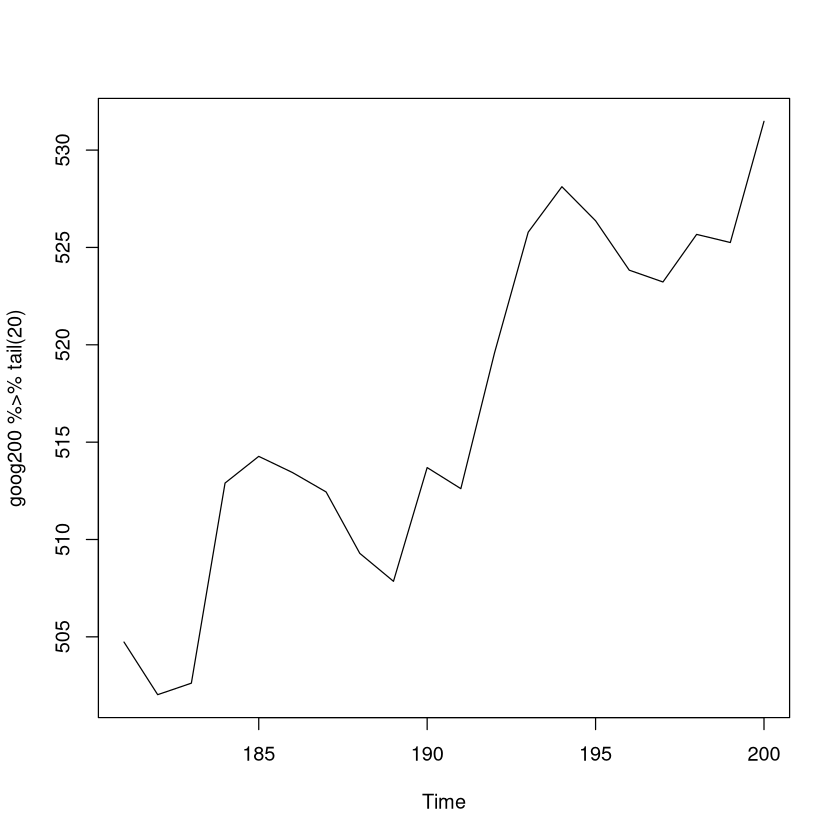

In [45]:
plot(goog200 %>% tail(20))

In [53]:
e <- tsCV(tail(goog200, 20), rwf, h=10) # offset of 10
e

,h=1,h=2,h=3,h=4,h=5,h=6,h=7,h=8,h=9,h=10
181,-2.702423,-2.111267,8.166901,9.537934,8.708344,7.709870,4.555359,3.119690,8.961701,7.878754
182,0.591156,10.869324,12.240357,11.410767,10.412293,7.257782,5.822113,11.664124,10.581177,17.555786
183,10.278168,11.649201,10.819611,9.821137,6.666626,5.230957,11.072968,9.990021,16.964630,23.164337
184,1.371033,0.541443,-0.457031,-3.611542,-5.047211,0.794800,-0.288147,6.686462,12.886169,15.221008
185,-0.829590,-1.828064,-4.982575,-6.418244,-0.576233,-1.659180,5.315429,11.515136,13.849975,12.101318
186,-0.998474,-4.152985,-5.588654,0.253357,-0.829590,6.145019,12.344726,14.679565,12.930908,10.392395
187,-3.154511,-4.590180,1.251831,0.168884,7.143493,13.343200,15.678039,13.929382,11.390869,10.784851
188,-1.435669,4.406342,3.323395,10.298004,16.497711,18.832550,17.083893,14.545380,13.939362,16.383454
189,5.842011,4.759064,11.733673,17.933380,20.268219,18.519562,15.981049,15.375031,17.819123,17.401825
190,-1.082947,5.891662,12.091369,14.426208,12.677551,10.139038,9.533020,11.977112,11.559814,17.784362


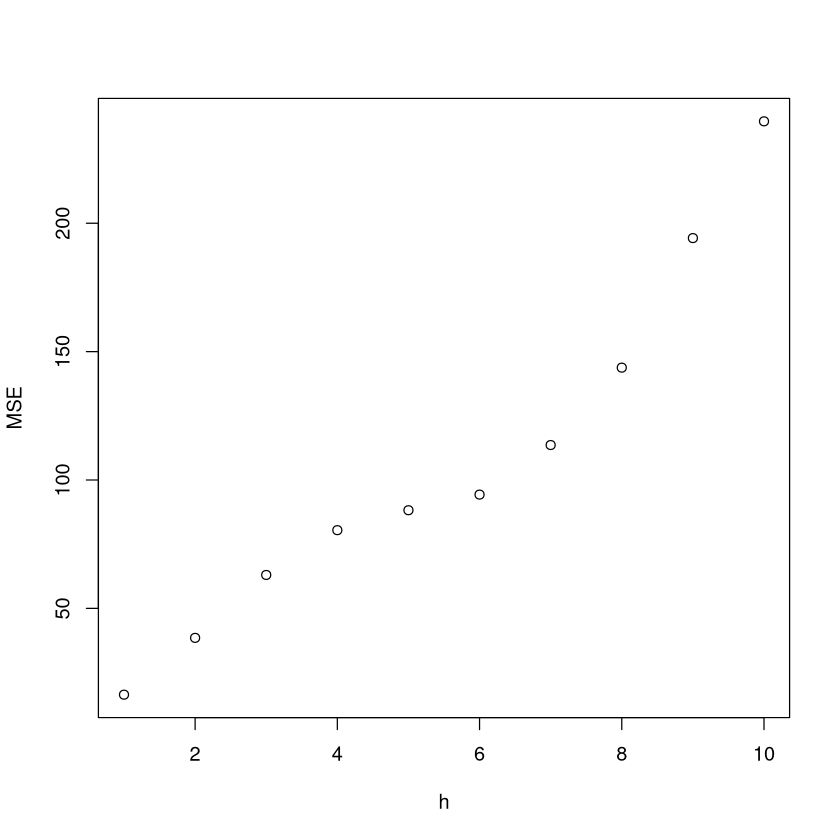

In [61]:
e^2 %>% colMeans(na.rm=TRUE) %>% plot(xlab='h', ylab='MSE')